#Evaluate Model PSG-Audio
This is a follow-on to the individual notebooks used in the fusion repository.

My goal is to make a single notebook to run the training and evaluation of modular models for consistency.  This notebook implements groupKfold on the training set and does not utilize the test set at all to avoid leakage during model evaluation and tuning.

Note the channel specific version of this was forked on 1/31/2023 as Evaluate_Channels_PSG-Audio.ipynb - in that notebook the code does more balancing of the dataset versus trying to push that to the model itself.

This is intended to be an interactive Jupyter notebook and not a stand alone .py file as with some of the other load_data code.

Author:  [Lee B. Hinkle](https://userweb.cs.txstate.edu/~lbh31/), [IMICS Lab](https://imics.wp.txstate.edu/), Texas State University, 2023



<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

TODO:
* This is very much an early version.
* Need to add f1 scores - despite dropping many "normal" to rebalance train the individual abnormal classes are still very unbalanced.
* Confusion matrix size needs to be adjusted and should also be converted to a figure to allow for saving to file.

# Imports

In [1]:
import os
import shutil
import time
from datetime import datetime
from datetime import date
from datetime import timedelta # for calculating training time
from random import randrange # for plotting samples
import numpy as np
import matplotlib.pyplot as plt # for plotting training curves
from tabulate import tabulate # for verbose tables, showing data
import tensorflow as tf
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
from tensorflow.keras.callbacks import EarlyStopping
#imports for computing and displaying output metrics
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import OneHotEncoder
import sys
import urllib.request # to get files from web w/o !wget
from shutil import unpack_archive # to unzip

In [2]:
my_dir = '.' # replace with absolute path if desired
interactive = True # runs simple calls for most cells
verbose = True

working_dir = os.path.join(my_dir,'psg_dataset') # create local directory
if not os.path.exists(working_dir):
    os.mkdir(working_dir)

# Get small or full processed PSG-Audio numpy arrays
See PSG-Audio_load_dataset_for_multi-output.ipynb for info, this is source of the arrays.


In [3]:
use_small = True # arrays are 1/10th the size for shorter download/train time
if use_small:
    version = "small"
    flist = ["small_x_train.npy", "small_y_train.npy", "small_sub_train.npy"]
else:
    version = "full"
    flist = ["x_train.npy", "y_train.npy", "sub_train.npy"]

# Commented Out:  Get processed PSG-Audio numpy arrays from Zenodo sandbox
Note - the large files took over 8 hours to download on my Macbook at home.


In [4]:
def get_proc_psg_audio(ppsga_flist):
    """checks for local file, if none downloads files in ppsga_flist from
     processed psg-audio repository on Zenodo into working_dir (global).
    :return: nothing"""
    ppsga_url = "https://sandbox.zenodo.org/record/1144199"
    for fname in flist:
        full_url = ppsga_url + "/files/" + fname
        ffname = os.path.join(working_dir, fname)
        if (os.path.exists(ffname)):
            if verbose:
                print ("Local",ffname,"found, skipping download")
        else:
            print("Downloading",ffname,"from",full_url)
            urllib.request.urlretrieve(full_url, filename=ffname)
    return
if interactive:
    start_time = time.time()
    #get_proc_psg_audio(ppsga_flist = flist) # comment out to avoid accident...
    end_time = time.time()
    download_time = timedelta(seconds=(end_time - start_time))
    print('Total Download time =',(str(download_time).split(".")[0]), 'HH:MM:SS')

Total Download time = 0:00:00 HH:MM:SS


# Copy files from google drive (instead of Zenodo - much faster, less portable)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
dataset_dir = '/content/drive/MyDrive/Processed_Datasets/PSG-Audio/PSG_12ch_90_10_5s_5s'
for fname in flist:
        print(fname, end=' ')
        if (os.path.exists(os.path.join(working_dir, fname))):
            if verbose:
                print ("Local",fname,"found, skipping download")
        else:
            print("copying")
            shutil.copy(os.path.join(dataset_dir, fname), working_dir)

small_x_train.npy copying
small_y_train.npy copying
small_sub_train.npy copying


In [7]:
def read_arrays():
    """read in the arrays - leaving test arrays out of this for now (just tuning model)"""
    if use_small:
        print("Reading in small arrays")
        X = np.load(os.path.join(working_dir, 'small_x_train.npy'))
        y = np.load(os.path.join(working_dir, 'small_y_train.npy'))
        sub = np.load(os.path.join(working_dir, 'small_sub_train.npy'))
    else:
        print("Reading in full arrays")
        X = np.load(os.path.join(working_dir, 'x_train.npy'))
        y = np.load(os.path.join(working_dir, 'y_train.npy'))
        sub = np.load(os.path.join(working_dir, 'sub_train.npy'))
    print("Reading arrays from npy files")
    headers = ("Array","shape", "data type")
    mydata = [("X:", X.shape, X.dtype),
            ("y:", y.shape, y.dtype),
            ("sub:", sub.shape, sub.dtype)]
    print("\n",tabulate(mydata, headers=headers))
    return X, y, sub
if interactive:
    X, y, sub = read_arrays()

Reading in small arrays
Reading arrays from npy files

 Array    shape             data type
-------  ----------------  -----------
X:       (21074, 500, 12)  float32
y:       (21074, 2)        int8
sub:     (21074, 1)        uint16


# Get flow and two respiratory bands Channels 9, 10, 11
This functionality has been moved into Evaluated_Channels_PSG-Audio.ipynb and will also be handled by the more complex models.

The model_1d_cnn_dense below expects a more processed form of the data, specifically with only one label not two.


In [8]:
model_dir = '/content/drive/MyDrive/Colab Notebooks/public_repositories/multi-output-psg/models'
#model_fname = 'model_1d_cnn_dense.py'
#model_fname = 'model_1d_cnn_globavgpool.py'
model_fname = 'model_1d_cnn_gap_all_sigs.py'

shutil.copy(os.path.join(model_dir, model_fname), my_dir)

# TODO need to figure out a way to force re-import without restart.

#import model_1d_cnn_dense as my_model
#import model_1d_cnn_globavgpool as my_model
import model_1d_cnn_gap_all_sigs as my_model

print ("Current model",my_model.description)

Current model 1D_CNN_GAP_all_sigs.py Concat input, 1D CNNs then Global Avg Pool


In [9]:
my_model.MAX_EPOCHS = 6 # just to test the code

## Run a stratified 5-fold group-based cross validation

running model 1D_CNN_GAP_all_sigs.py Concat input, 1D CNNs then Global Avg Pool
Fold 0:
build_model input shapes (16622, 500, 12) (16622, 5)
build_model modified shapes (16622, 500, 3) (16622, 5)
train_model input shapes (16622, 500, 12) (16622, 5) (4452, 500, 12) (4452, 5)
train_model modified shapes (16622, 500, 3) (16622, 5) (4452, 500, 3) (4452, 5)
Epoch 1/6
130/130 [==============================] - 2s 11ms/step - loss: 457.2391 - accuracy: 0.5951 - val_loss: 1096.6305 - val_accuracy: 0.8884
Epoch 2/6
130/130 [==============================] - 1s 8ms/step - loss: 1030.7312 - accuracy: 0.4984 - val_loss: 125.9492 - val_accuracy: 0.3935
Epoch 3/6
130/130 [==============================] - 1s 7ms/step - loss: 1380.8177 - accuracy: 0.4137 - val_loss: 1257.3130 - val_accuracy: 0.4708
Epoch 4/6
130/130 [==============================] - 1s 7ms/step - loss: 1566.7344 - accuracy: 0.4227 - val_loss: 930.0960 - val_accuracy: 0.7410
Epoch 5/6
130/130 [==============================] - 1s 7ms

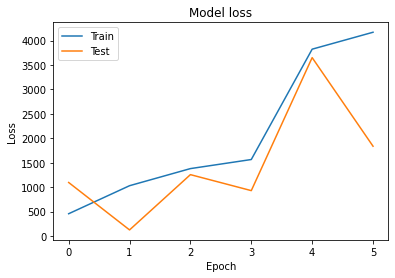

Fold 1:
build_model input shapes (17141, 500, 12) (17141, 5)
build_model modified shapes (17141, 500, 3) (17141, 5)
train_model input shapes (17141, 500, 12) (17141, 5) (3933, 500, 12) (3933, 5)
train_model modified shapes (17141, 500, 3) (17141, 5) (3933, 500, 3) (3933, 5)
Epoch 1/6
134/134 [==============================] - 2s 12ms/step - loss: 124.7343 - accuracy: 0.5857 - val_loss: 343.7957 - val_accuracy: 0.7221
Epoch 2/6
134/134 [==============================] - 1s 9ms/step - loss: 531.2314 - accuracy: 0.4489 - val_loss: 559.4587 - val_accuracy: 0.4450
Epoch 3/6
134/134 [==============================] - 1s 7ms/step - loss: 728.2343 - accuracy: 0.4391 - val_loss: 1966.2854 - val_accuracy: 0.0000e+00
Epoch 4/6
134/134 [==============================] - 1s 7ms/step - loss: 803.7856 - accuracy: 0.4503 - val_loss: 1070.8046 - val_accuracy: 0.0659
Epoch 5/6
134/134 [==============================] - 1s 7ms/step - loss: 1197.1055 - accuracy: 0.4359 - val_loss: 1342.0654 - val_accuracy

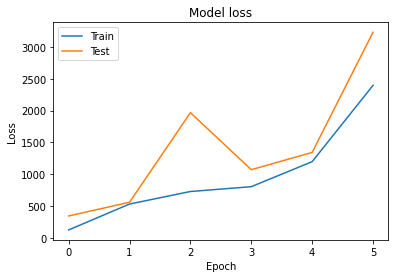

Fold 2:
build_model input shapes (16978, 500, 12) (16978, 5)
build_model modified shapes (16978, 500, 3) (16978, 5)
train_model input shapes (16978, 500, 12) (16978, 5) (4096, 500, 12) (4096, 5)
train_model modified shapes (16978, 500, 3) (16978, 5) (4096, 500, 3) (4096, 5)
Epoch 1/6
133/133 [==============================] - 2s 10ms/step - loss: 180.6515 - accuracy: 0.5502 - val_loss: 624.7306 - val_accuracy: 0.2854
Epoch 2/6
133/133 [==============================] - 1s 9ms/step - loss: 495.0206 - accuracy: 0.4856 - val_loss: 130.3155 - val_accuracy: 0.7002
Epoch 3/6
133/133 [==============================] - 1s 9ms/step - loss: 815.0103 - accuracy: 0.4679 - val_loss: 1764.0682 - val_accuracy: 0.8005
Epoch 4/6
133/133 [==============================] - 1s 9ms/step - loss: 924.6335 - accuracy: 0.4698 - val_loss: 271.8007 - val_accuracy: 0.5735
Epoch 5/6
133/133 [==============================] - 1s 7ms/step - loss: 1847.8079 - accuracy: 0.4838 - val_loss: 2620.7156 - val_accuracy: 0.0

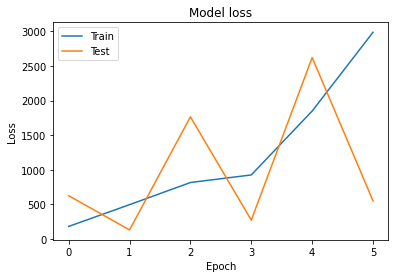

Fold 3:
build_model input shapes (16763, 500, 12) (16763, 5)
build_model modified shapes (16763, 500, 3) (16763, 5)
train_model input shapes (16763, 500, 12) (16763, 5) (4311, 500, 12) (4311, 5)
train_model modified shapes (16763, 500, 3) (16763, 5) (4311, 500, 3) (4311, 5)
Epoch 1/6
131/131 [==============================] - 2s 9ms/step - loss: 362.6920 - accuracy: 0.5343 - val_loss: 1165.4908 - val_accuracy: 0.0209
Epoch 2/6
131/131 [==============================] - 1s 7ms/step - loss: 893.1854 - accuracy: 0.4466 - val_loss: 1817.6462 - val_accuracy: 0.0000e+00
Epoch 3/6
131/131 [==============================] - 1s 7ms/step - loss: 993.2967 - accuracy: 0.4467 - val_loss: 1373.5043 - val_accuracy: 0.0000e+00
Epoch 4/6
131/131 [==============================] - 1s 7ms/step - loss: 1422.7020 - accuracy: 0.4441 - val_loss: 2572.1221 - val_accuracy: 0.0000e+00
Epoch 5/6
131/131 [==============================] - 1s 7ms/step - loss: 2536.4478 - accuracy: 0.4465 - val_loss: 4379.8301 - va

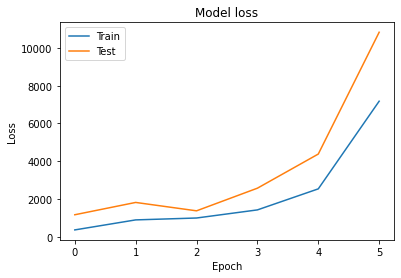

Fold 4:
build_model input shapes (16792, 500, 12) (16792, 5)
build_model modified shapes (16792, 500, 3) (16792, 5)
train_model input shapes (16792, 500, 12) (16792, 5) (4282, 500, 12) (4282, 5)
train_model modified shapes (16792, 500, 3) (16792, 5) (4282, 500, 3) (4282, 5)
Epoch 1/6
132/132 [==============================] - 2s 14ms/step - loss: 228.7776 - accuracy: 0.5563 - val_loss: 528.6019 - val_accuracy: 0.7391
Epoch 2/6
132/132 [==============================] - 1s 8ms/step - loss: 361.6233 - accuracy: 0.4095 - val_loss: 190.7820 - val_accuracy: 7.0061e-04
Epoch 3/6
132/132 [==============================] - 1s 7ms/step - loss: 956.7664 - accuracy: 0.3936 - val_loss: 1497.4214 - val_accuracy: 0.9402
Epoch 4/6
132/132 [==============================] - 1s 7ms/step - loss: 1562.7559 - accuracy: 0.4082 - val_loss: 2154.1001 - val_accuracy: 0.8538
Epoch 5/6
132/132 [==============================] - 1s 7ms/step - loss: 2713.5994 - accuracy: 0.4029 - val_loss: 3181.2751 - val_accurac

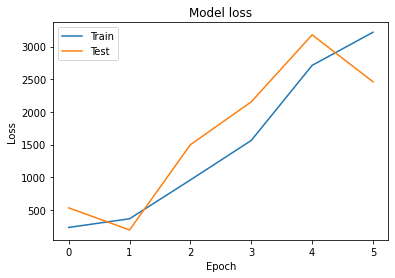

------------------------------------------------------------------------
Score per fold
> Fold 1 - Loss: 1.8e+03 - Accuracy: 76.15%
> Fold 2 - Loss: 3.2e+03 - Accuracy: 64.71%
> Fold 3 - Loss: 5.5e+02 - Accuracy: 63.67%
> Fold 4 - Loss: 1.1e+04 - Accuracy: 1.32%
> Fold 5 - Loss: 2.5e+03 - Accuracy: 0.00%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 41.17 (+- 33.37)
------------------------------------------------------------------------
Total Training time = 0:00:48 HH:MM:SS
running model 1D_CNN_GAP_all_sigs.py Concat input, 1D CNNs then Global Avg Pool
> Accuracy: 41.17 (+- 33.37)


In [11]:
def run_cross_val():
    """runs a five fold cross-validation pass. returns accuracy string"""
    print ("running model",my_model.description)

    # Define per-fold score containers
    acc_per_fold = []
    loss_per_fold = []
    y_pred_per_fold = []
    y_test_per_fold = []

    skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

    start_time = time.time()

    for i, (train_index, test_index) in enumerate(skf.split(X, y[:,0], groups=sub)):
        print(f"Fold {i}:")

        x_train, y_train = X[train_index], y[train_index]
        x_test, y_test = X[test_index], y[test_index]
        
        # One Hot Encode: Note for respiratory there are 5 relatively frequent
        # categories but others can appear in only a portion of the folds.

        enc = OneHotEncoder(handle_unknown = 'ignore', sparse=False)
        y_train = enc.fit_transform(y_train)
        y_test = enc.transform(y_test)

        model = my_model.build_model(x_train, y_train)
        history, model = my_model.train_model(model, x_train, y_train,
                                            x_test, y_test)  
        val_acc = history.history['val_accuracy'][-1]
        val_loss = history.history['val_loss'][-1] 

        acc_per_fold.append(val_acc * 100)
        loss_per_fold.append(val_loss)

        # Generate predictions
        # y_pred = model.predict(x_test, verbose = 0)
        x_test2 = x_test[:,:,9:12] # this should be in model...
        y_pred = model.predict(x_test2, verbose = 0)

        y_pred = np.argmax(y_pred, axis=1)
        y_pred_per_fold.append(y_pred)
        y_test_per_fold.append(np.argmax(y_test, axis=1))

        # Plot training & validation loss values
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('Model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.show()

    # == Provide average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
    #     print('------------------------------------------------------------------------')
        print(f'> Fold {i+1} - Loss: {loss_per_fold[i]:4.2} - Accuracy: {acc_per_fold[i]:4.2f}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold):4.2f} (+- {np.std(acc_per_fold):5.4})')
    acc_str = temp = str(f'> Accuracy: {np.mean(acc_per_fold):4.2f} (+- {np.std(acc_per_fold):5.4})')
    print('------------------------------------------------------------------------')

    # Show total training time
    end_time = time.time()
    train_time = timedelta(seconds=(end_time - start_time))
    print('Total Training time =',(str(train_time).split(".")[0]), 'HH:MM:SS')
    # to plot confusion matrices return concat versions of y
    y_pred = np.concatenate(y_pred_per_fold)
    y_test = np.concatenate(y_test_per_fold)
    return acc_str, y_pred, y_test
result, y_pred, y_test = run_cross_val()
print ("running model",my_model.description)
print(result)

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-13-d3c1185b1bb4>:23: RuntimeWarning: invalid value encountered in true_divid

              precision    recall  f1-score   support

           0       0.87      0.45      0.60     18820
           1       0.11      0.03      0.05      2254
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0

    accuracy                           0.41     21074
   macro avg       0.25      0.12      0.16     21074
weighted avg       0.79      0.41      0.54     21074

Normalized confusion matrix
[[0.45 0.03 0.46 0.06]
 [0.55 0.03 0.38 0.04]
 [ nan  nan  nan  nan]
 [ nan  nan  nan  nan]]


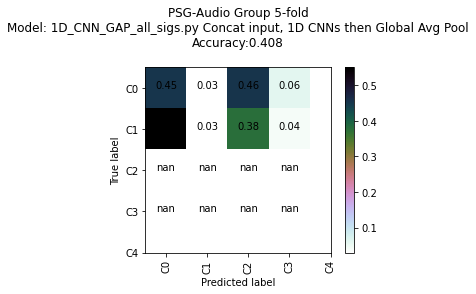

In [13]:
# == Confusion matrix ==
from sklearn.metrics import confusion_matrix
import itertools

#moved to evaluate function
#y_pred = np.concatenate(y_pred_per_fold)
#y_test = np.concatenate(y_test_per_fold)

# print(classification_report(y_test, y_pred, target_names=class_names))
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes,
                            normalize=True,
                            title='Confusion matrix',
                            cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
            print(np.array(cm).round(2)) # to limit digits
        else:
            print('Confusion matrix, without normalization')
            print(cm)
    
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes,rotation=90)
        plt.yticks(tick_marks, classes)
    
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
title = 'PSG-Audio Group 5-fold\n'
title +=  "Model: " + my_model.description + '\n'
#title += "Predicting " + labels + " using " + ch_group + '\n'
title += 'Accuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred))+'\n'
class_names = ['C0','C1','C2','C3','C4'] # placeholder for now
plot_confusion_matrix(cm, classes=class_names, title=title, cmap='cubehelix_r')

# STOP - the following code is to load the data from and save figures to google drive.
You are welcome to use it, but it is untested outside of my environment.

In [ ]:
def get_load_data_utils():
    """checks for local file, if none downloads from IMICS repository.
    Assumes a global my_dir has been defined (default is my_dir = ".")
    :return: nothing"""
    fname = 'load_data_utils.py'
    ffname = os.path.join(my_dir,fname)
    if (os.path.exists(ffname)):
        if verbose:
            print ("Local load_data_utils.py found, skipping download")
    else:
        print("Downloading",fname, "from IMICS git repo")
        urllib.request.urlretrieve("https://raw.githubusercontent.com/imics-lab/load_data_time_series/main/load_data_utils.py", filename=fname)
if interactive:
    get_load_data_utils()

In [ ]:
from load_data_utils import get_env_info
from load_data_utils import get_log_ffname
from load_data_utils import tabulate_numpy_arrays
from load_data_utils import channel_powerset
if interactive:
    print('My env_info: \n' + get_env_info())

My env_info: 
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
GPU: name, driver_version, memory.total [MiB]
Tesla T4, 510.47.03, 15360 MiB



In [ ]:
save_log = False # set to False to avoid a problem if accidentally run...
# alternate confusion matrix with fig object to save
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm,
                    index = class_names, 
                    columns = class_names)
fig = plt.figure(figsize=(6.5,5))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='cubehelix_r')
#plt.title('Insert title here\n
#plt.title('Accuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.title('Accuracy:{0:.3f}'.format(accuracy_score(y_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout() # keeps labels from being cutoff when saving as pdf
plt.show()
if save_log:
    log_ffname = get_log_ffname(
    log_file_dir = '/content/drive/My Drive/Colab_Run_Results',
    base_fname = "PSG_Multi_Output_Work")
    print("Saving results to", log_ffname)
    with open(log_ffname, "a") as file_object:
        file_object.write("Generated by Evaluate_Model_PSG-Audio.ipynb\n")
        file_object.write("Processed PSG with 5 fold via sklearn GroupKFold\n")
        file_object.write("Final Accuracy: %0.3f\n" %accuracy_score(y_test, y_pred))
        file_object.write("Classification Report\n")
        file_object.write(classification_report(y_test, y_pred, target_names=class_names))
        file_object.write("Confusion Matrix\n")
        file_object.write(str(cm))
    cm_ffname = log_ffname.split('.')[0] + '_cm.pdf'
    print("saving cm plot as",cm_ffname)
    fig.savefig(cm_ffname,format='pdf', dpi=1200)
    full_model_fname = log_ffname.split('.')[0] + '_model.txt'
    with open(full_model_fname, "a") as file_object:
        model.summary(print_fn=lambda x: file_object.write(x + '\n'))
        #acknowledgement https://stackoverflow.com/users/14951382/sparklingdew
    #plot using keras function
    #ref https://keras.io/api/utils/model_plotting_utils/
    full_mplot_fname = log_ffname.split('.')[0] + '_model.png'
    keras.utils.plot_model(model, to_file=full_mplot_fname, show_shapes=True)